In [1]:
import pandas as pd 
import numpy as np 

In [3]:
df = pd.read_csv("data/spambase_augmented.csv")

In [4]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

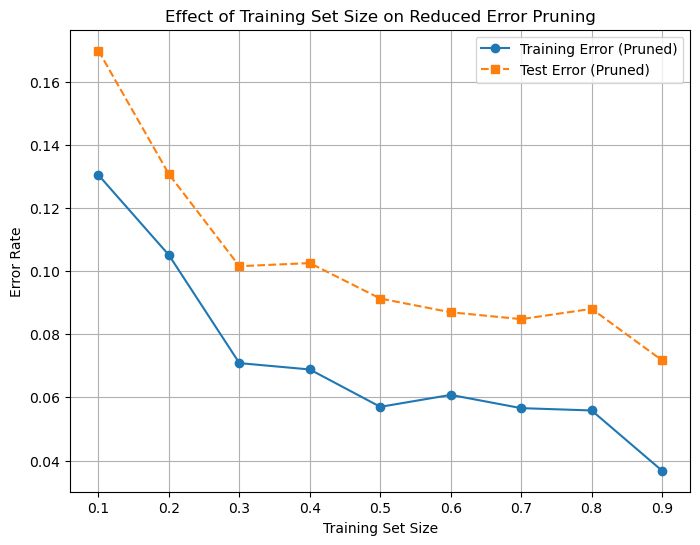

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, _tree

train_sizes = np.linspace(0.1, 0.9, 9)  # Train sizes from 10% to 90%
train_error = []
test_error = []

def prune_tree(tree, X_val, y_val):
    """
    Prune a decision tree by iteratively removing nodes if it improves validation accuracy.
    """
    def prune_node(node):
        """
        Recursively prune the tree starting from the leaves.
        """
        if tree.tree_.children_left[node] != _tree.TREE_LEAF:
            # Recursively prune left and right children
            prune_node(tree.tree_.children_left[node])
            prune_node(tree.tree_.children_right[node])

            # Backup original predictions
            left_child, right_child = tree.tree_.children_left[node], tree.tree_.children_right[node]
            original_values = tree.tree_.value[node].copy()

            # Make the node a leaf by setting its children to -1
            tree.tree_.children_left[node] = _tree.TREE_LEAF
            tree.tree_.children_right[node] = _tree.TREE_LEAF

            # Compute validation accuracy after pruning
            y_val_pred = tree.predict(X_val)
            pruned_accuracy = accuracy_score(y_val, y_val_pred)

            # Restore the original node if pruning didn't improve accuracy
            if pruned_accuracy < prune_tree.best_val_accuracy:
                tree.tree_.children_left[node] = left_child
                tree.tree_.children_right[node] = right_child
                tree.tree_.value[node] = original_values
            else:
                prune_tree.best_val_accuracy = pruned_accuracy  # Update best accuracy

    prune_tree.best_val_accuracy = accuracy_score(y_val, clf.predict(X_val))  # Store best accuracy
    prune_node(0)  # Start pruning from the root

# Vary training size
for train_size in train_sizes:
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=42, stratify=y)

    # Further split training set for validation (10% of train size)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42, stratify=y_train)

    clf = DecisionTreeClassifier(random_state=42)
    clf.fit(X_train, y_train)

    # Apply pruning
    prune_tree(clf, X_val, y_val)

    # Compute train error
    y_train_pred = clf.predict(X_train)
    cur_training_err = 1 - accuracy_score(y_train, y_train_pred)

    # Compute test error
    y_test_pred = clf.predict(X_test)
    cur_test_error = 1 - accuracy_score(y_test, y_test_pred)

    train_error.append(cur_training_err)
    test_error.append(cur_test_error)

# Plot results
plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_error, label="Training Error (Pruned)", marker='o', linestyle='-')
plt.plot(train_sizes, test_error, label="Test Error (Pruned)", marker='s', linestyle='--')
plt.xlabel("Training Set Size")
plt.ylabel("Error Rate")
plt.title("Effect of Training Set Size on Reduced Error Pruning")
plt.legend()
plt.grid(True)
plt.show()